<a href="https://colab.research.google.com/github/enyeneraph/ML-pack-capstone-project/blob/main/Aliu/Aliu_icu_covid_preds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 14 kB/s 


In [ ]:

import numpy  as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.impute   import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics  import accuracy_score, auc, roc_curve, precision_recall_curve, roc_auc_score, precision_score, recall_score, average_precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost  import XGBClassifier

plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd '/content/gdrive/MyDrive'

/content/gdrive/MyDrive


In [ ]:
!ls

 0utput.csv		  Final_scrap.gsheet	        Output.gsheet
 0utput_new.csv		  Harafat.vcf		        planets
 archive		 'Introduction to Timeseries'   results1.csv
'Colab Notebooks'	  kaggle		        results.csv
 condacolab_install.log   kaggle.json		        results.gsheet
 Final_scrap.csv	  Output.csv		       'Untitled document.gdoc'


In [ ]:
!ls

Kaggle_Sirio_Libanes_ICU_Prediction.xlsx


In [ ]:
# Read data
raw_data = pd.read_excel('Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')
raw_data.sample(5)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
1801,360,1,70th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.940345,-0.940345,...,-0.985892,-1.0,0.037037,-0.292308,-0.415094,-0.728814,-0.107143,0.789474,0.037037,-0.292308,-0.415094,-0.724138,-0.107143,0.789474,0.195876,-0.0500,-0.282051,-0.642857,0.318681,0.919192,-0.282051,-0.502703,-0.537313,-0.757576,-0.275362,0.789474,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
172,34,0,30th,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
859,171,0,20th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.980115,-0.980115,...,-0.978029,-1.0,0.066618,-0.309063,-0.511676,-0.560329,-0.161245,0.836894,0.086420,-0.292308,-0.547170,-0.586207,-0.142857,0.842105,-0.360825,-0.4750,-0.658120,-0.571429,0.098901,0.858586,0.094017,-0.189189,-0.238806,-0.454545,-0.159420,0.947368,-0.147826,-0.226994,-0.358779,-0.764706,-0.666667,-0.878788,-0.360870,-0.214765,-0.427833,-0.741935,-0.663881,-0.881390,ABOVE_12,0
106,21,1,70th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.769634,-0.769634,-0.769634,-0.769634,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.268293,-0.268293,-0.268293,-0.268293,-1.0,-0.764521,-0.764521,...,-0.978029,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-4,0
1408,281,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.604938,-0.516923,-0.535849,-0.267797,-0.007143,0.694737,-0.604938,-0.569231,-0.490566,-0.310345,0.035714,0.736842,-0.360825,-0.2875,-0.470085,-0.214286,0.274725,0.838384,-0.692308,-0.491892,-0.567164,-0.272727,0.014493,0.789474,-0.947826,-0.754601,-0.8625

In [ ]:
# Data Preparation
raw_data['AGE_PERCENTIL'] = raw_data['AGE_PERCENTIL'].str.replace('Above ','').str.extract(r'(.+?)th')
raw_data['WINDOW'] = raw_data['WINDOW'].str.replace('ABOVE_12','12-more').str.extract(r'(.+?)-')

# Missingness as features
raw_data['row_missingness'] = raw_data.isnull().sum(axis=1)

# Mean imputation
mean_impute  = SimpleImputer(strategy='mean')
imputed_data = mean_impute.fit_transform(raw_data)
imputed_data = pd.DataFrame(imputed_data, columns = raw_data.columns)

In [ ]:
# Check imbalance
raw_data['ICU'].value_counts()

0    1410
1     515
Name: ICU, dtype: int64

In [ ]:
def evaluate(model, testing_set_x, testing_set_y):
    predictions = model.predict_proba(testing_set_x)
    
    accuracy  = accuracy_score(testing_set_y, predictions[:,1] >= 0.5)
    roc_auc   = roc_auc_score(testing_set_y, predictions[:,1])
    precision = precision_score(testing_set_y, predictions[:,1] >= 0.5)
    recall    = recall_score(testing_set_y, predictions[:,1] >= 0.5)
    pr_auc    = average_precision_score(testing_set_y, predictions[:,1])
    
    result = pd.DataFrame([[accuracy, precision, recall, roc_auc, pr_auc]], columns=['Accuracy', 'Precision', 'Recall', 'ROC_auc','PR_auc'])
    return(result)

In [ ]:
def run_experiment(df, model_class, n = 100, **kwargs):
    results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'ROC_auc','PR_auc'])
    for i in range(n):
        # Compose dataset
        train_x, test_x = train_test_split(df.drop('PATIENT_VISIT_IDENTIFIER', axis=1),
                               test_size = 0.3,
                               stratify  = df['ICU'],
                               random_state = i
                                )
        
        train_y = train_x.pop('ICU')
        test_y  = test_x.pop('ICU')
        
        # Train Model
        model = model_class(**kwargs)
        model.fit(train_x, train_y)
         
        # Evaluate results
        current_result = evaluate(model, test_x, test_y)
        results = results.append(current_result)
        
    return(results.reset_index(drop=True))


In [ ]:
def print_results(df, plot = True, extras = False, color='dodgerblue'):
    print('|||||||||||||||||||||||||||||||||||||||||||||||||||||||')
    print('[ Experiment Results ]')
    print('Accuracy:   {}'.format(df.Accuracy.mean()))
    print('Precision:  {}'.format(df.Precision.mean()))
    print('Recall:     {}'.format(df.Recall.mean()))
    print('ROC Auc:    {}'.format(df.ROC_auc.mean()))
    print('PR Auc:     {}'.format(df.PR_auc.mean()))
    print('|||||||||||||||||||||||||||||||||||||||||||||||||||||||')
    
    if plot:
        fig = px.box(df.melt(var_name='metric'),
                       y = 'metric',
                       x = 'value',
                       title = 'Distribution of Metric Values Across 100 Runs',
                       color_discrete_sequence=[color]
                      )

        fig.update_xaxes(title='Metric')
        fig.update_yaxes(title='Value')

        fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 00)',
                           'paper_bgcolor': 'rgba(240, 240, 240, 100)'})
        fig.show()
        
        
    if extras:
        print('Also, the maximum results were:')
        print('    Accuracy:   {}'.format(df.Accuracy.max()))
        print('    Precision:  {}'.format(df.Precision.max()))
        print('    Recall:     {}'.format(df.Recall.max()))
        print('    ROC Auc:    {}'.format(df.ROC_auc.max()))
        print('    PR Auc:     {}'.format(df.PR_auc.max()))


In [ ]:
rf_experiment = run_experiment(imputed_data, model_class = RandomForestClassifier, **rf_optimal)
print_results(rf_experiment, color = '#3F3F3F')

|||||||||||||||||||||||||||||||||||||||||||||||||||||||
[ Experiment Results ]
Accuracy:   0.8710034602076122
Precision:  0.8334091104993129
Recall:     0.6494838709677423
ROC Auc:    0.9115936093952564
PR Auc:     0.8380843667194773
|||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [ ]:
rf_optimal = {
              'n_estimators':2100,
              'max_depth':27,
              'max_features':0.15,
              'max_samples':0.5363991145732665,
              'min_samples_split':2,
              'min_samples_leaf':4,
              'n_jobs':-1,
              'random_state':451,
            }

In [ ]:
optimal_1 = {'learning_rate': 0.02956340635276464,
 'n_estimators': 3831,
 'num_leaves': 101,
 'max_depth': 28,
 'max_bin': 211,
 'bagging_freq': 9,
 'bagging_fraction': 0.9292245982209768,
 'feature_fraction': 0.95,
 'lambda_l1': 2.50667180728151,
 'lambda_l2': 4.010110517090694,
 'drop_rate': 0.5917712341785191,
 'min_child_samples': 15,
 'min_child_weight': 3,
 'min_split_gain': 0.0,
 'scale_pos_weight': 0.283126887443018,
 'boosting_type': 'gbdt',
 'bagging_seed': 42,
 'metric': 'auc',
 'verbosity': -1,
 'random_state': 451,
 'max_drop': 50}

In [ ]:
optimal_2 = {'learning_rate': 0.05744913989406643,
 'n_estimators': 2067,
 'num_leaves': 8,
 'max_depth': 27,
 'max_bin': 384,
 'bagging_freq': 5,
 'bagging_fraction': 0.7038650070406707,
 'feature_fraction': 0.4806588217742334,
 'lambda_l1': 2.841137907985995,
 'lambda_l2': 5.983397074528167,
 'drop_rate': 0.490746746058113,
 'min_child_samples': 3,
 'min_child_weight': 0,
 'min_split_gain': 0.0,
 'scale_pos_weight': 9.91024410907254,
 'boosting_type': 'gbdt',
 'bagging_seed': 42,
 'metric': 'auc',
 'verbosity': -1,
 'random_state': 451,
 'max_drop': 50}

In [ ]:
optimal_3 = {'learning_rate': 0.05744913989406643,
 'n_estimators': 2067,
 'num_leaves': 8,
 'max_depth': 27,
 'max_bin': 384,
 'bagging_freq': 5,
 'bagging_fraction': 0.7038650070406707,
 'feature_fraction': 0.4806588217742334,
 'lambda_l1': 2.841137907985995,
 'lambda_l2': 5.983397074528167,
 'drop_rate': 0.490746746058113,
 'min_child_samples': 3,
 'min_child_weight': 0,
 'min_split_gain': 0.0,
 'scale_pos_weight': 0.91024410907254,
 'boosting_type': 'gbdt',
 'bagging_seed': 42,
 'metric': 'auc',
 'verbosity': -1,
 'random_state': 451,
 'max_drop': 50}

In [ ]:
# Model #1
lgbm_experiment_1 = run_experiment(imputed_data, model_class = LGBMClassifier, **optimal_1)
print_results(lgbm_experiment_1, color = '#8400E8')

|||||||||||||||||||||||||||||||||||||||||||||||||||||||
[ Experiment Results ]
Accuracy:   0.8632006920415223
Precision:  0.9121044064601381
Recall:     0.5429032258064517
ROC Auc:    0.9197180660413332
PR Auc:     0.8498296039190805
|||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [ ]:
import shap

In [ ]:
# Model #2
lgbm_experiment_2 = run_experiment(imputed_data, model_class = LGBMClassifier, **optimal_2)
print_results(lgbm_experiment_2, color = '#00E800')

|||||||||||||||||||||||||||||||||||||||||||||||||||||||
[ Experiment Results ]
Accuracy:   0.8443944636678198
Precision:  0.6742957001887488
Recall:     0.8150967741935482
ROC Auc:    0.921403416456951
PR Auc:     0.8558094401788894
|||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [ ]:
# Model #3
lgbm_experiment_3 = run_experiment(imputed_data, model_class = LGBMClassifier, **optimal_3)
print_results(lgbm_experiment_3, extras=True, color = '#00A4E8')

|||||||||||||||||||||||||||||||||||||||||||||||||||||||
[ Experiment Results ]
Accuracy:   0.8804498269896195
Precision:  0.8333076259925631
Recall:     0.6940000000000002
ROC Auc:    0.927086860367574
PR Auc:     0.8614578033887422
|||||||||||||||||||||||||||||||||||||||||||||||||||||||


Also, the maximum results were:
    Accuracy:   0.903114186851211
    Precision:  0.8956521739130435
    Recall:     0.7806451612903226
    ROC Auc:    0.9500953252497523
    PR Auc:     0.8958803136331814


In [ ]:
# Lets train a single model first
train_x, test_x = train_test_split(imputed_data.drop('PATIENT_VISIT_IDENTIFIER', axis=1),
                                   test_size = 0.3,
                                   stratify  = imputed_data['ICU'],
                                   random_state = 451
                                  )
        
train_y = train_x.pop('ICU')
test_y  = test_x.pop('ICU')


model = LGBMClassifier(**optimal_3)
model.fit(train_x, train_y)

LGBMClassifier(bagging_fraction=0.7038650070406707, bagging_freq=5,
               bagging_seed=42, boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, drop_rate=0.490746746058113,
               feature_fraction=0.4806588217742334, importance_type='split',
               lambda_l1=2.841137907985995, lambda_l2=5.983397074528167,
               learning_rate=0.05744913989406643, max_bin=384, max_depth=27,
               max_drop=50, metric='auc', min_child_samples=3,
               min_child_weight=0, min_split_gain=0.0, n_estimators=2067,
               n_jobs=-1, num_leaves=8, objective=None, random_state=451,
               reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=0.91024410907254,
               silent=True, subsample=1.0, subsample_for_bin=200000, ...)

In [ ]:
# Extract shap values
explainer   = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


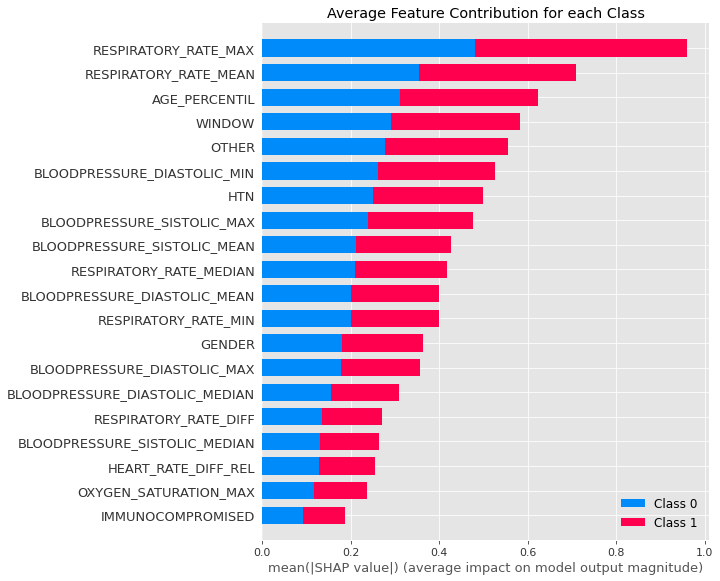

In [ ]:
# Average feature contribution
plt.title('Average Feature Contribution for each Class')
shap.summary_plot(shap_values, train_x, plot_type="bar")

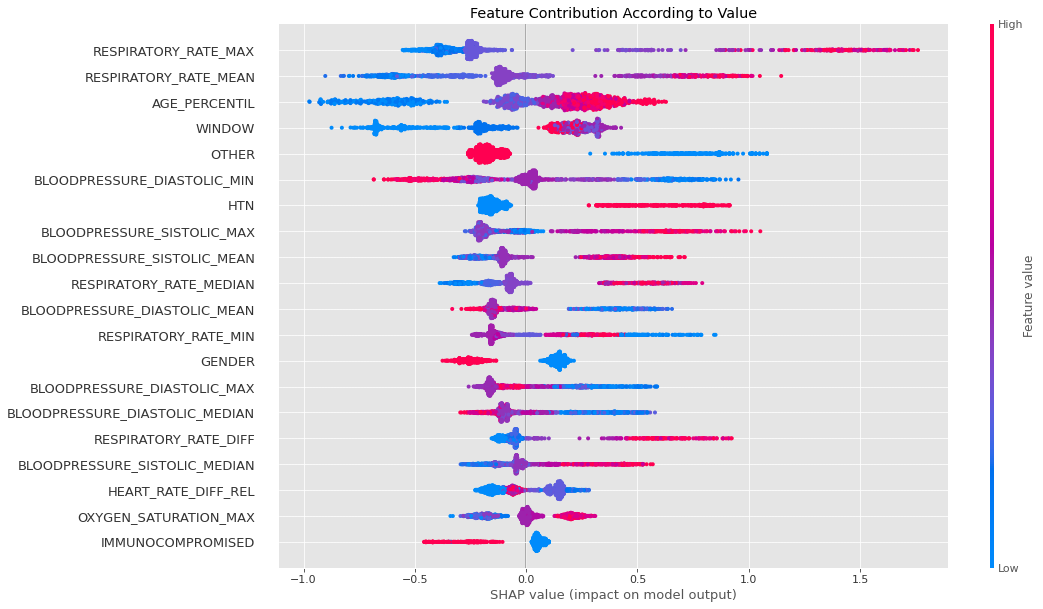

In [ ]:
# Granular feature contribution plot
plt.title('Feature Contribution According to Value')
shap.summary_plot(shap_values[1], train_x, plot_size = (15,10))

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0:50], train_x[0:50])